In [1]:
#
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import time

# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

# solver 
from simpeg.utils.solver_utils import get_default_solver

In [3]:
Solver = get_default_solver()

# define survey and model parameters

In [4]:
# conductivity values
rho_back = 100

sigma_target = 0.1
sigma_back = 1/rho_back

# target geometry
target_thickness = 40
target_depth = 200 + target_thickness/2 * np.r_[-1, 1]

print(f"target conductances: {sigma_target * target_thickness}")

target conductances: 4.0


In [5]:
# transmitter
tx_height = 30
tx_radius = 10

# receiver times
rx_times = 1e-3 * np.logspace(-1, 1, 30)  # 30 time-channels between 0.1ms and 10ms

In [6]:
def diffusion_distance(sigma, t):
    return 1260 * np.sqrt(t/sigma)

In [7]:
# minimum diffusion distance (max conductivity, earliest time) 
diffusion_distance(sigma_target, rx_times.min())

np.float64(39.844698518121575)

In [8]:
# maximum diffusion distance (background conductivity, latest time)
diffusion_distance(sigma_back, rx_times.max())

np.float64(1260.0)

# 1D mesh

In [9]:
cell_size = 5
layer_thicknesses = np.hstack([[cell_size]*int(300/cell_size), cell_size * np.logspace(0, 1.5, 20)])

In [10]:
# create a mesh with one extra layer so we can regularize the value that goes to "infinite" depth
mesh = discretize.TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], origin="0")

Text(0.5, 0, 'depth (m)')

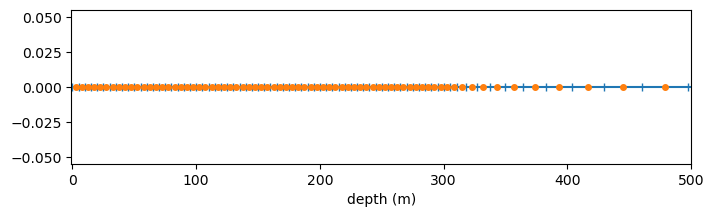

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(mesh.nodes, np.zeros_like(mesh.nodes), "-|")
ax.plot(mesh.cell_centers, np.zeros_like(mesh.cell_centers), "o", ms=4)
ax.set_xlim([-1, 500])
ax.set_xlabel("depth (m)")

In [12]:
rx_z = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, 0, tx_height], times=rx_times, orientation="z"
)

src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, tx_height], radius=tx_radius, receiver_list=[rx_z], #waveform=waveform
)

survey = tdem.Survey([src])

simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, sigmaMap=maps.ExpMap(mesh)  # invert for log conductivity
)

# create data 

In [13]:
np.diff(target_depth)

array([40.])

In [14]:
m_true = np.log(np.r_[sigma_back, sigma_target, sigma_back])
simulation_3layer = tdem.Simulation1DLayered(
    survey=tdem.Survey([src]), thicknesses=np.r_[target_depth.min(), target_thickness], sigmaMap=maps.ExpMap(nP=3)
)

In [15]:
d_background = simulation_3layer.dpred(np.log(sigma_back)*np.ones(3))
d_true = simulation_3layer.dpred(m_true)

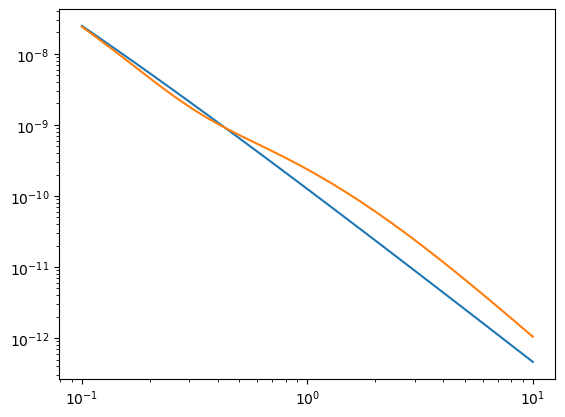

In [16]:
fig, ax = plt.subplots(1, 1)
ax.loglog(rx_times*1e3, -d_background, label="background")
ax.loglog(rx_times*1e3, -d_true, label="background")

# set up the inversion

In [17]:
dobs = d_true
data_invert = data.Data(survey, dobs=dobs, relative_error=0.05)

In [18]:
class SaveInversionProgress(directives.InversionDirective):
    """
    A custom directive to save items of interest during the course of an inversion
    """
    
    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results 
        self.inversion_results = {
            "iteration":[],
            "beta":[],
            "phi_d":[],
            "phi_m":[],
            "phi_m_small":[],
            "phi_m_smooth":[],
            "dpred":[],
            "model":[]
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append 
        the new values to our dictionary
        """
        
        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["beta"].append(self.invProb.beta)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["phi_m"].append(self.invProb.phi_m)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        self.inversion_results["model"].append(self.invProb.model)
        
        # grab the components of the regularization and evaluate them here
        # the regularization has a list of objective functions  
        # objfcts = [smallness, smoothness_x, smoothness_z]
        # and the multipliers contain the alpha values
        # multipliers = [alpha_s, alpha_x, alpha_z]
        reg = self.reg.objfcts[0] 
        phi_s = reg.objfcts[0](self.invProb.model) * reg.multipliers[0]
        phi_x = reg.objfcts[1](self.invProb.model) * reg.multipliers[1]
        
        self.inversion_results["phi_m_small"].append(phi_s)
        self.inversion_results["phi_m_smooth"].append(phi_x)

In [42]:
def setup_inversion(alpha_s=0.1, alpha_x=1): 
    
    # define misfit and regularization 
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_invert)
    reg = regularization.WeightedLeastSquares(
        mesh, 
        alpha_s=alpha_s, alpha_x=alpha_x, 
        reference_model=np.log(sigma_back),
    )

    opt = optimization.InexactGaussNewton(maxIter=30, tolCG=1e-3)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
    beta_cooling = directives.BetaSchedule(coolingRate=2, coolingFactor=1.5)

    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = SaveInversionProgress()

    # stop the inversion when we reach the target misfit -- here we slightly overfit to explore models
    target_misfit = directives.TargetMisfit()

    # The directives are defined as a list.
    directives_list = [
        starting_beta,
        beta_cooling,
        target_misfit,
        save_iteration,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    
    return inv, save_iteration

In [48]:
inv, save_iteration = setup_inversion(alpha_s=1e-2, alpha_x=1)
# Run the inversion
starting_model = np.log(sigma_back)*np.ones(mesh.n_cells)
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.22.2.dev41+ge21040475

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.86e+03  2.36e+03  4.95e-32  2.36e+03    4.62e+02      0              
   1  2.86e+03  1.93e+03  6.34e-02  2.11e+03    8.18e+01      0              
   2  1.90e+03  1.85e+03  8.70e-02  2.01e+03    1.58e+02      0   Skip BFGS  
   3  1.90e+03  1.63e+03  1.76e-01  1.96e+03    4.54e+01      0              
   4  1.27e+03  1.57e+03  2.04e-01  1.83e+03    1.55e+02      0   Skip BFGS  
   5  1.27e+03  1.29e+03  3.74e-01  1.76e+03    5.71e+0

Text(0.5, 0, 'conductivity (S/m)')

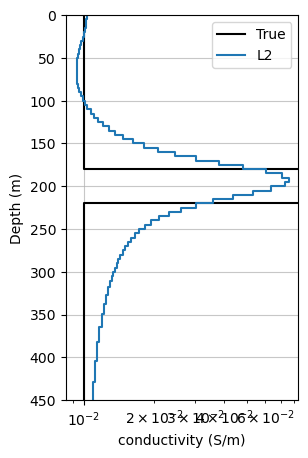

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(3, 5))

plot_1d_layer_model(simulation_3layer.thicknesses, np.exp(m_true), ax=ax, color="k", label="True")
plot_1d_layer_model(mesh.h[0], np.exp(recovered_model), ax=ax, label="L2")

ax.set_ylim([450, 0])
# ax.set_xlim([6e-3, 2e-1])
ax.grid("both", alpha=0.7)
ax.legend()

ax.set_xlabel("conductivity (S/m)")

Text(0, 0.5, 'db/dt')

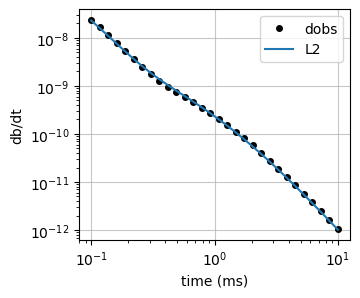

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

ax.loglog(rx_times*1e3, -dobs, "ko", label="dobs", ms=4)
ax.loglog(rx_times*1e3, -simulation.dpred(recovered_model), label="L2")
# ax.loglog(rx_times*1e3, -sim1d.dpred(recovered_model_l1), label="L1")
# ax.loglog(rx_times*1e3, -sim1d.dpred(recovered_model_l0), label="L0")

ax.legend()
ax.grid("both", alpha=0.7)
ax.set_xlabel("time (ms)")
ax.set_ylabel("db/dt")

In [51]:
inversion_results = save_iteration.inversion_results
inversion_results.keys()

dict_keys(['iteration', 'beta', 'phi_d', 'phi_m', 'phi_m_small', 'phi_m_smooth', 'dpred', 'model'])

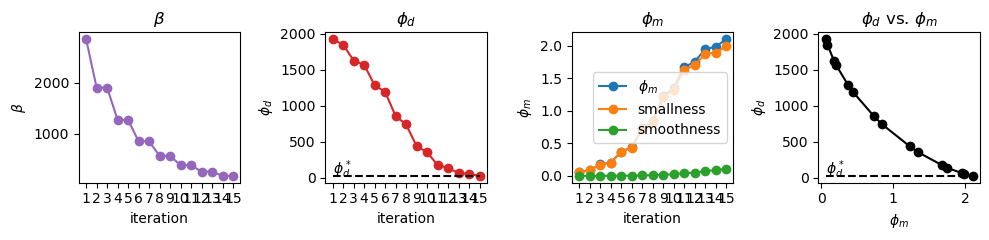

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(10, 2.5))

ax[0].plot(inversion_results["iteration"], inversion_results["beta"], "-o", color="C4")
ax[0].set_title("$\\beta$")
ax[0].set_ylabel("$\\beta$")

ax[1].plot(inversion_results["iteration"], inversion_results["phi_d"], "-o", color="C3")
ax[1].plot(inversion_results["iteration"], survey.nD*np.ones_like(inversion_results["iteration"]), "--", color="k" )
ax[1].text(1, survey.nD*2, "$\phi_d^*$")
ax[1].set_title("$\phi_d$")
ax[1].set_ylabel("$\phi_d$")

ax[2].plot(inversion_results["iteration"], inversion_results["phi_m"], "-o", label="$\phi_m$")
ax[2].plot(inversion_results["iteration"], inversion_results["phi_m_small"], "-o", label="smallness")
ax[2].plot(inversion_results["iteration"], inversion_results["phi_m_smooth"], "-o", label="smoothness")
ax[2].set_title("$\phi_m$")
ax[2].set_ylabel("$\phi_m$")
ax[2].legend()

for a in ax[:3]:
    a.set_xlabel("iteration")
    a.set_xticks(inversion_results["iteration"])

ax[3].plot(inversion_results["phi_m"], inversion_results["phi_d"],  "-o", color="k")
ax[3].plot(inversion_results["phi_m"], survey.nD*np.ones_like(inversion_results["iteration"]), "--", color="k" )
ax[3].text(inversion_results["phi_m"][0], survey.nD*2, "$\phi_d^*$")
ax[3].set_xlabel("$\phi_m$")
ax[3].set_ylabel("$\phi_d$")
ax[3].set_title("$\phi_d$ vs. $\phi_m$")

plt.tight_layout()